# import data

In [1]:
import platform
import pandas as pd
from datetime import datetime, timedelta, time
ohlcv_data = pd.read_pickle('/Users/bokie/code/python/CMS/可转债套利/cms/stock_data_min_new.pkl')
print(ohlcv_data.keys())
for k,v in ohlcv_data.items():
    print(k,' data length: ',len(v))
print('数据起始日期',v.index[0])
print('数据结束日期',v.index[-1])
print('113642.SH数据起始日期',ohlcv_data['113642.SH'].index[0])
print('113642.SH数据结束日期',ohlcv_data['113642.SH'].index[-1])

dict_keys(['123046.SZ', '300587.SZ', '113642.SH', '603185.SH', '110061.SH', '600674.SH', '128081.SZ', '002203.SZ'])
123046.SZ  data length:  31460
300587.SZ  data length:  31460
113642.SH  data length:  13552
603185.SH  data length:  31460
110061.SH  data length:  31460
600674.SH  data length:  31460
128081.SZ  data length:  31460
002203.SZ  data length:  31460
数据起始日期 2021-12-13 09:30:00
数据结束日期 2022-06-28 15:00:00
113642.SH数据起始日期 2022-04-06 09:30:00
113642.SH数据结束日期 2022-06-28 15:00:00


# bond-stock pair

In [2]:
from lib2to3.pytree import convert

# cbond_pair = ['128081.SZ','002203.SZ']
# part = 1
# convert_price = 9.69
# stock_volume = 100/convert_price #整个回测期间不变


# cbond_pair = ['123046.SZ','300587.SZ']
# part = 1 
# convert_price = 6.73
# stock_volume = 100/convert_price  # 2021-12-13至2022-03-23
# part = 2
# convert_price = 6.74
# stock_volume = 100/convert_price  # 2022-03-24至2022-06-28


# cbond_pair = ['110061.SH','600674.SH']
# part = 1
# convert_price = 9.2
# stock_volume = 100/convert_price #整个回测期间不变


cbond_pair = ['113642.SH','603185.SH']
# part = 1
# convert_price = 145.66
# stock_volume = 100/convert_price  # 2022-04-06至2022-06-02
part = 2
convert_price = 102.61
stock_volume = 100/convert_price  # 2022-06-03至2022-06-28


In [3]:
cbond_pair_price = pd.DataFrame([])
cbond_pair_price = pd.concat([ohlcv_data[cbond_pair[0]]['close'],ohlcv_data[cbond_pair[1]]['close']],axis=1)
cbond_pair_price.columns = cbond_pair
cbond_pair_price = cbond_pair_price.dropna()
if cbond_pair[0] == '128081.SZ' or cbond_pair[0] == '110061.SH':
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':]
elif cbond_pair[0] == '123046.SZ' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2021-12-13 15:00:00':'2022-03-23 15:00:00']
elif cbond_pair[0] == '123046.SZ' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-03-25 15:00:00':]
elif cbond_pair[0] == '113642.SH' and part == 1:
    cbond_pair_price = cbond_pair_price.loc['2022-04-07 15:00:00':'2022-06-02 15:00:00']
elif cbond_pair[0] == '113642.SH' and part == 2:
    cbond_pair_price = cbond_pair_price.loc['2022-06-03 15:00:00':]

# cbond_pair_price = cbond_pair_price.loc['2022-04-06 15:00:00':]
# cbond_pair_price.to_excel('cbond_pair_price.xlsx')
# cbond_pair_price.to_csv('cbond_pair_price.csv')
# cbond_pair_price

In [4]:
print(len(cbond_pair_price))
cbond_pair_price.head(10)
cbond_pair_price.tail(10)

4058


,113642.SH,603185.SH
2022-06-28 14:48:00,154.05,136.20
2022-06-28 14:49:00,154.30,136.16
2022-06-28 14:50:00,154.07,136.16
2022-06-28 14:51:00,154.77,136.25
2022-06-28 14:52:00,155.10,136.50
2022-06-28 14:53:00,155.33,136.43
2022-06-28 14:54:00,155.00,136.34
2022-06-28 14:55:00,154.97,136.71
2022-06-28 14:56:00,154.64,136.98
2022-06-28 15:00:00,154.89,136.80


# signal calculate

先算cbond_return(日内收益率，相对于昨日收盘价)，再算cbond_position，计算cbond_position中用到的open_threshold和close_threshold分别是价格止盈价格止损信号。时间止损信号则是，每日15点时强制平仓

In [5]:
cbond_return = pd.DataFrame([])

cbond_preclose = cbond_pair_price.iloc[0,0] # 初始时刻的bond前收盘价
stock_preclose = cbond_pair_price.iloc[0,1] # 初始时刻的stock前收盘价

for index,row in cbond_pair_price.iterrows():
    
    cbond_return.loc[index,cbond_pair[0]] = row[cbond_pair[0]]/cbond_preclose - 1 # 算日内的return
    cbond_return.loc[index,cbond_pair[1]] = row[cbond_pair[1]]/stock_preclose - 1

    if index.time()==time(15,0,0):  #算完日内return，迭代到今日价格的最后一个time bar的时候，将其设为前收盘价
        cbond_preclose = row[cbond_pair[0]]    # 日内return指标用 现价/昨日收盘价 计算
        stock_preclose = row[cbond_pair[1]]
        
# 检查df是否有空值
cbond_return.isnull().sum(axis=0)  # 按列统计
cbond_return.isnull().sum(axis=1) # 按行统计
cbond_return.isnull().sum(axis=1).sum() # 统计整张表

0

In [6]:
pd.set_option('display.max_rows', None)
# pair moving trend: diff = cbond reutrn - stock return 
cbond_return['diff'] = cbond_return[cbond_pair[0]] - cbond_return[cbond_pair[1]]

len(cbond_return)

4058

In [7]:
# 画出收益率的时间序列图，对diff序列做平稳性检验
# plot pair moving trend: diff = cbond reutrn - stock return 

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Scatter(name=cbond_pair[0], x=cbond_return.index, y=cbond_return[cbond_pair[0]]),
    go.Scatter(name=cbond_pair[1], x=cbond_return.index, y=cbond_return[cbond_pair[1]]),
    go.Scatter(name='diff', x=cbond_return.index, y=cbond_return['diff']),
])
fig.show()


# test stationary
from statsmodels.tsa.stattools import adfuller
if adfuller(cbond_return['diff'])[1] < 0.001:
    print("This cbond-stock pair is stationary!")
else:
    print("This cbond-stock pair is not stationary!")

This cbond-stock pair is stationary!


In [8]:
open_threshold = 0.01  # 0.005 ~ 0.01 ~ 0.015 间隔是0.001
# open_threshold = 0.008
close_threshold = 0.001 #  0 ~ 0.001 ~ 0.002 ~ 0.003
open_flag = 0
cbond_position = pd.DataFrame([])
cbond_position.index = cbond_return.index
for index,row in cbond_return.iterrows():
    if abs(row['diff']) > open_threshold and open_flag==0:  # diff大于开仓阈值，并且无仓位就开仓
        open_flag = 1
        if row['diff'] > 0:  # diff 绝对值大于0.01并且diff是正数，说明bond偏高了，做空之，stock则反向开仓
            cbond_position.loc[index,cbond_pair[0]] = -1*open_flag  #short bond, long stock
            cbond_position.loc[index,cbond_pair[1]] = open_flag
        else:                # diff 绝对值大于0.01并且diff是负数，说明bond偏低了，做多之，stock则反向开仓
            cbond_position.loc[index,cbond_pair[0]] = open_flag     #long bond, short stock
            cbond_position.loc[index,cbond_pair[1]] = -1*open_flag
    
    elif abs(row['diff']) < close_threshold and open_flag==1: # diff小于平仓阈值，并且有仓位就平仓
    # elif abs(row['diff']) < close_threshold and open_flag==1: # diff小于平仓阈值，并且有仓位就平仓
        open_flag = 0   # diff 绝对值小于阈值时，认为股债的偏移效应减弱，走势收敛，此时平仓
        cbond_position.loc[index,cbond_pair[0]] = open_flag
        cbond_position.loc[index,cbond_pair[1]] = open_flag
    
    else: # diff介于开仓阈值和平仓阈值之间，并且diff大于0，short bond long stock,小于0则short stock long bond
        if row['diff'] > 0:
            cbond_position.loc[index,cbond_pair[0]] = -1*open_flag
            cbond_position.loc[index,cbond_pair[1]] = open_flag
        else:
            cbond_position.loc[index,cbond_pair[0]] = open_flag
            cbond_position.loc[index,cbond_pair[1]] = -1*open_flag

    if index.time()==time(15,0,0): # 每日收盘时必须平仓（时间止损信号）
        open_flag = 0 
        cbond_position.loc[index,cbond_pair[0]] = open_flag
        cbond_position.loc[index,cbond_pair[1]] = open_flag
# cbond_position.to_csv('cbond_position.csv')

In [9]:
df_signal = pd.concat([cbond_pair_price,cbond_return,cbond_position],axis=1)
df_signal.columns = ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
# df_signal.to_csv('df_signal.csv')


In [10]:
trade_times = 0
trade_occur = []
for i in range(len(df_signal)-1):
    # print(df_signal.values[i])
    # if cbond_position.values[i][-1] != cbond_position.values[i+1][-1]:
    if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
        trade_times += 1
        trade_occur.append(df_signal.index.tolist()[i])
        trade_occur.append(df_signal.index.tolist()[i+1])
    # assert i<100
print('trade_times: ',trade_times)

trade_times:  69


In [11]:
# diff = bond return - stock return
len(trade_occur)
# df_signal.loc[trade_occur]
# df_signal.loc[time(15,0,0)]
# df_signal

138

# backtest

In [12]:
# 用来记录交易流水的表格,一边遍历df_signal，一边填入内容到流水表格里

import numpy as np
cols = ['balance','signal','bond price','stock price','bond hold','stock hold','commission','tax','reverse open']
df_trade = pd.DataFrame(
    data = [[0,np.nan,np.nan,np.nan,0,0,0,0,np.nan]],
    columns=cols
    ) 

balance_last = 0 # 现金账户初始余额

bond_hold = 0 # 债券持有数量
stock_hold = 0 # 股票持有数量

commission_rate = 2/10000 # 佣金买卖万二
tax_rate = 1/1000 #



for i in range(len(df_signal)-1):
    if df_signal.values[i][-1] != df_signal.values[i+1][-1]:
        index = df_signal.index[i+1]

    # df_signal的columns
    # ['bond_price','stock_price','bond_rtn','stock_rtn','diff','bond_pos','stock_pos']
        signal = str(int(df_signal.values[i+1][-2]))+str(int(df_signal.values[i+1][-1]))
        
        bond_price = df_signal.values[i+1][0] 

        stock_price = df_signal.values[i+1][1]

        commission = (bond_price + stock_price * stock_volume) * commission_rate

        reverse_open = False #表明这笔交易，是否包含平仓后再反向开仓的操作

        if signal == '00' and stock_hold == stock_volume: #有股票持仓并且需要卖出平仓时，有印花税
            tax = stock_price * tax_rate * stock_volume
        else:
            tax = 0

        if signal == '00':
            balance_last += bond_hold*bond_price
            balance_last += stock_hold*stock_price
            
            bond_hold = 0
            stock_hold = 0
            

        if signal == '1-1':
            '''
            加一个检测之前持仓的模块,如果之前因为-11的信号有持仓,需要先平掉(即买债卖股票),同时再反向开仓
            '''
            reverse_flag = False
            if bond_hold == -1 and stock_hold == 1*stock_volume:
                bond_hold = 0
                stock_hold = 0
                balance_last -= bond_price 
                balance_last += stock_price * stock_volume
                commission *= 2 # 因为平掉之后再反向开仓，手续费double
                tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税
                reverse_flag = True
                reverse_open = True

            bond_hold += 1
            stock_hold += (-1 * stock_volume)
            # stock_hold += stock_volume
            balance_last -= bond_price
            balance_last += stock_price * stock_volume
            
            if reverse_flag:
                tax *= 2 #平仓然后反向开仓的时候 已经计算过tax了，直接double
            else:
                tax = stock_price * tax_rate * stock_volume # 卖股票要收印花税

        if signal == '-11':
            '''
            加一个检测之前持仓的模块,如果之前因为1-1的信号有持仓,需要先平掉(卖债买股票),同时再反向开仓
            '''
            if bond_hold == 1 and stock_hold == -1*stock_volume:
                bond_hold = 0
                stock_hold = 0
                balance_last += bond_price
                balance_last -= stock_price * stock_volume
                commission *= 2 # 因为平掉之后再反向开仓，手续费double
                                # 买股票无印花税
                reverse_open = True
            bond_hold += -1
            stock_hold += (1 * stock_volume)
            # stock_hold += stock_volume
            balance_last += bond_price
            balance_last -= stock_price * stock_volume
        

        balance = balance_last

        line = [balance,signal,bond_price,stock_price,bond_hold,stock_hold,commission,tax,reverse_open]
        # df_trade.loc[index,['balance','asset','signal','bond price','stock price','commission','tax']] = line
        # df_trade.loc[index,cols] = [0,0,np.nan,np.nan,np.nan,0,0,0,0]
        df_trade.loc[index,cols] = line

       
# df_trade

# result

In [13]:
df_trade['net value'] = df_trade['balance'] + \
                        df_trade['bond price']*df_trade['bond hold'] + \
                        df_trade['stock price']*df_trade['stock hold'] - \
                        df_trade['commission'] - \
                        df_trade['tax']

In [14]:
df_trade

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
0,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000,0.000000,NaN,NaN
2022-06-06 09:41:00,-24.440604,1-1,138.64,117.18,1.0,-0.974564,0.050568,0.114199,False,-0.164767
2022-06-06 09:45:00,2.022180,00,138.83,115.30,0.0,0.000000,0.050239,0.000000,False,1.971941
2022-06-06 09:51:00,-23.114020,1-1,139.55,117.40,1.0,-0.974564,0.050793,0.114414,False,1.856974
2022-06-06 15:00:00,0.857166,00,143.94,123.10,0.0,0.000000,0.052782,0.000000,False,0.804384
2022-06-07 09:31:00,-21.630503,1-1,145.77,126.50,1.0,-0.974564,0.053810,0.123282,False,0.680073
2022-06-07 15:00:00,1.298219,00,142.42,122.61,0.0,0.000000,0.052382,0.000000,False,1.245837
2022-06-08 09:32:00,25.515132,-11,141.34,120.18,-1.0,0.974564,0.051693,0.000000,False,1.246527
2022-06-08 09:33:00,2.647013,00,141.57,121.80,0.0,0.000000,0.052054,0.118702,False,2.476257
2022-06-08 09:39:00,26.837501,-11,142.60,121.50,-1.0,0.974564,0.052202,0.000000,False,2.594811


In [16]:
#把交易序列单个时间节点的扩展到整个序列
# assert False
df_nv = df_trade[['net value']].iloc[1:]
df_nv['time'] = df_nv.index
df_tmp = df_signal[['diff']]
df_tmp['time'] = df_tmp.index
#  merge之后再前向往后fillna
df_nv_full =  pd.merge(df_nv,df_tmp,how='outer').sort_values(by='time').fillna(method='ffill').fillna(0)
df_nv_full.index = df_tmp.index
df_nv_full = df_nv_full[['net value']]


/var/folders/4y/tm0f5s2n00s3g71c6qrvd0bh0000gn/T/ipykernel_72934/788458400.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:>

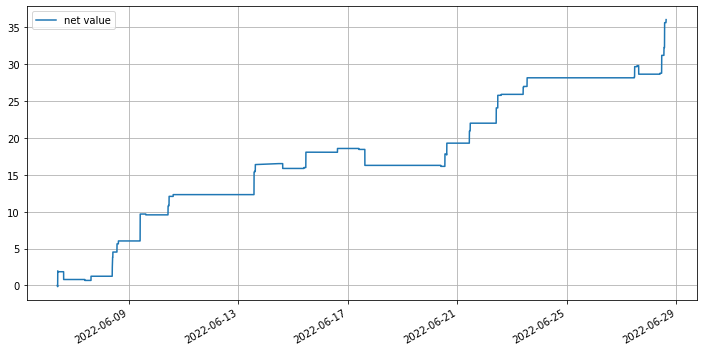

In [17]:
# df_nv_full.loc[df_nv_full.index[0]:df_trade.index[1]] = [0] #第一笔交易发生之前net value设置为0
df_nv_full.plot(figsize=(12,6),grid=True,)

In [18]:
len(df_trade)

70

# statistic & analysis

In [19]:
# 胜率重新修改   key: 一个来回能不能挣钱
# 盈亏比：盈利来回的平均盈利/亏损来回的平均亏损
# 单边规模：每次交易额的一半
# 交易来回数
# 平均每日来回数 （只算交易日）
# 交易天数
# 时间止损次数，价格止损次数
# 另外两对pair搞好数据重新回测

In [20]:
print(len(df_trade))
# df_trade

70


# win rate calculate

In [21]:
df_trade_2 = df_trade.copy(deep=True)
rounds = [] #只包含单个来回，每2条交易记录组成一个来回的组
reverse_rounds = [] # 包含多个来回，信号之间包含平仓同时反向开仓的组
for i in range(len(df_trade)-1,0,-1):
# for i in range(len(df_trade)-1,-1,-1):
    if df_trade_2.iloc[i-1,:]['signal'] == '00':
        round = df_trade_2.iloc[i:,:]
        if len(round)>2:
            reverse_rounds.append(round)
        else:
            rounds.append(round)
        df_trade_2 = df_trade_2.iloc[:i]

In [22]:
num_round = len(rounds)
for i in reverse_rounds:
    num_round += len(i)-1
print('single round:',num_round)
print('reverse rounds: ',len(reverse_rounds))

single round: 36
reverse rounds:  3


In [23]:
rounds[0]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
2022-06-28 14:51:00,57.755176,-11,154.77,136.25,-1.0,0.974564,0.057511,0.00000,False,35.711994
2022-06-28 15:00:00,36.185515,00,154.89,136.80,0.0,0.000000,0.057642,0.13332,False,35.994553


In [24]:
rounds[-1]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
2022-06-06 09:51:00,-23.114020,1-1,139.55,117.4,1.0,-0.974564,0.050793,0.114414,False,1.856974
2022-06-06 15:00:00,0.857166,00,143.94,123.1,0.0,0.000000,0.052782,0.000000,False,0.804384


In [25]:
reverse_rounds[0]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
2022-06-28 13:12:00,13.433071,1-1,152.80,137.32,1.0,-0.974564,0.057325,0.133827,False,32.214806
2022-06-28 13:36:00,54.924922,-11,153.54,136.26,-1.0,0.974564,0.114534,0.000000,True,34.064463
2022-06-28 13:37:00,14.546966,1-1,153.10,136.38,1.0,-0.974564,0.114404,0.265822,True,34.355717
2022-06-28 13:38:00,56.051535,-11,153.79,136.51,-1.0,0.974564,0.114731,0.000000,True,35.184519
2022-06-28 13:39:00,35.769505,00,153.31,136.50,0.0,0.000000,0.057268,0.133028,False,35.579209


In [26]:
reverse_rounds[-1]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
2022-06-08 09:39:00,26.837501,-11,142.60,121.50,-1.0,0.974564,0.052202,0.000000,False,2.594811
2022-06-08 09:45:00,-18.489609,1-1,142.34,122.80,1.0,-0.974564,0.104807,0.239353,True,3.829787
2022-06-08 10:05:00,4.574549,00,143.53,123.61,0.0,0.000000,0.052799,0.000000,False,4.521750


In [27]:
# win = 0
# lose = 0
# win_profit = 0
# lose_profit = 0
# for i in rounds:
#     if i.iloc[1,-1] - i.iloc[0,-1]>0:
#         win += 1
#         win_profit += i.iloc[1,-1] - i.iloc[0,-1]
#     else:
#         lose += 1
#         lose_profit += i.iloc[1,-1] - i.iloc[0,-1]
# print('win: ',win)
# print('lose: ',lose)
# print('win profit: ',win_profit)
# print('lose profit: ',lose_profit)

# normal round win&lose stat

In [28]:
return_in_rounds = []
win = 0
lose = 0
win_profit = 0
lose_profit = 0
for i in rounds:
    
    tmp_profit = (i['net value'] - i['net value'].shift(1)).values[-1]
    single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
    
    return_in_round = tmp_profit/single_round_cost
    return_in_rounds.append(return_in_round)
    
    
    if tmp_profit>0:
        win += 1
        win_profit += tmp_profit
    else:
        lose += 1
        lose_profit += tmp_profit
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print(len(return_in_rounds))

win:  23
lose:  5
win profit:  30.3185736768346
lose profit:  -5.131994547120179
28


In [29]:
# # for i in range(len(reverse_rounds)-1):
# for single_reverse_round in reverse_rounds:
#     # single_reverse_round = reverse_rounds[i]
#     net_values = single_reverse_round['net value'].tolist()
#     close_values = []
#     for i in range(len(single_reverse_round)-2):
#         df_tmp = single_reverse_round.iloc[i,:]
#         # ['balance','signal','bond price','stock price','bond hold','stock hold','commission','tax','reverse open']
#         bond_price = single_reverse_round.iloc[i+1,2]
        
#         stock_price = single_reverse_round.iloc[i+1,3]

#         commission = (bond_price + stock_price * stock_volume) * commission_rate

#         if df_tmp['signal'] == '1-1':
#             tax = 0
#         elif df_tmp['signal'] == '-11':
#             tax = stock_price * tax_rate * stock_volume

#         close_value = df_tmp['balance'] + \
#                         df_tmp['bond hold']*bond_price +\
#                             df_tmp['stock hold']*stock_price \
#                                 - commission - tax
#         # print(close_value)
#         close_values.append(close_value)
#     # print('net_values: ',net_values)
#     # print('close_values: ',close_values)
#     complete_round_values = []
#     for i in range(len(net_values)-1):
#         if i < len(close_values):
#             complete_round_values.append(net_values[i])
#             complete_round_values.append(close_values[i])
#     complete_round_values += net_values[i:]
#     # print('complete_round_values: \n',complete_round_values)

#     complete_round_values = pd.Series(complete_round_values)
#     profits = complete_round_values - complete_round_values.shift(1)
#     profits = profits.dropna()
#     for i in profits.values:
#         if i > 0:
#             win += 1
#             win_profit += i
#         else:
#             lose += 1
#             lose_profit += i

In [30]:
# reverse_rounds[0]

In [31]:
# #用于测试拆分交易流水算法

# reverse_rounds0_reconstruct = []
# for i in range(0,len(reverse_rounds[0])-1): #4-2

#     # tmp_cols = reverse_rounds[0].columns
#     # tmp_index = reverse_rounds[0].iloc[i,:].reset_index()
#     m = reverse_rounds[0].iloc[i,:].tolist()
#     n = reverse_rounds[0].iloc[i+1,:].tolist()
#     # reverse_rounds0_reconstruct.append(m)
#     tmp_balance = m[0] + n[2]*m[4] + n[3]*m[5] 
#     tmp_commission = n[6]/2
#     tmp_tax = n[7]/2
#     tmp_nv =  tmp_balance - tmp_commission - tmp_tax
    
#     insert_line  = [tmp_balance,'00',np.nan,np.nan,0,0,tmp_commission,tmp_tax,'-',tmp_nv]
#     reverse_rounds0_reconstruct.append(m)
#     reverse_rounds0_reconstruct.append(insert_line)
# # reverse_rounds0_reconstruct.append(n)    
# tmp_cols = reverse_rounds[0].columns
# reverse_rounds0_reconstruct[-1] = reverse_rounds[0].iloc[-1,:].tolist()
# tmp_round = pd.DataFrame(reverse_rounds0_reconstruct[:],columns=tmp_cols)
# tmp_round
# for index,row in tmp_round.iterrows():
#     if row['reverse open'] == True:
#         tmp_round.loc[index,['commission','tax']] = tmp_round.loc[index,['commission','tax']]/2
# tmp_round = tmp_round.fillna(method='bfill')
# tmp_round['new nv'] = tmp_round['balance'] + tmp_round['bond price']*tmp_round['bond hold'] + tmp_round['stock price']*tmp_round['stock hold'] - tmp_round['commission'] - tmp_round['tax']
# tmp_round

# reverse round reconstruct

In [32]:
''' 
先把连续反向开仓的信号拆开
e.g.  1-1 -11 00 ---> 1-1 00 -11 00
'''

reverse_rounds_reconstruct = []
for reverse_round in reverse_rounds:
    reverse_rounds0_reconstruct = []
    for i in range(0,len(reverse_round)-1): #4-2

        # tmp_cols = reverse_rounds[0].columns
        # tmp_index = reverse_rounds[0].iloc[i,:].reset_index()
        m = reverse_round.iloc[i,:].tolist()
        n = reverse_round.iloc[i+1,:].tolist()
        # reverse_rounds0_reconstruct.append(m)
        tmp_balance = m[0] + n[2]*m[4] + n[3]*m[5] 
        tmp_commission = n[6]/2
        tmp_tax = n[7]/2
        tmp_nv =  tmp_balance - tmp_commission - tmp_tax
        
        insert_line  = [tmp_balance,'00',np.nan,np.nan,0,0,tmp_commission,tmp_tax,'-',tmp_nv]
        reverse_rounds0_reconstruct.append(m)
        reverse_rounds0_reconstruct.append(insert_line)
    # reverse_rounds0_reconstruct.append(n)    
    tmp_cols = reverse_round.columns
    reverse_rounds0_reconstruct[-1] = reverse_round.iloc[-1,:].tolist()
    tmp_round = pd.DataFrame(reverse_rounds0_reconstruct[:],columns=tmp_cols)
    tmp_round
    for index,row in tmp_round.iterrows():
        if row['reverse open'] == True:
            tmp_round.loc[index,['commission','tax']] = tmp_round.loc[index,['commission','tax']]/2
    tmp_round = tmp_round.fillna(method = 'bfill')
    reverse_rounds_reconstruct.append(tmp_round)
    tmp_round['new nv'] = tmp_round['balance'] + tmp_round['bond price']*tmp_round['bond hold'] + tmp_round['stock price']*tmp_round['stock hold'] - tmp_round['commission'] - tmp_round['tax']

reverse_rounds_reconstruct[0]


,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value,new nv
0,13.433071,1-1,152.80,137.32,1.0,-0.974564,0.057325,0.133827,False,32.214806,32.214806
1,34.178996,00,153.54,136.26,0.0,0.000000,0.057267,0.000000,-,34.121729,34.121729
2,54.924922,-11,153.54,136.26,-1.0,0.974564,0.057267,0.000000,True,34.064463,34.121729
3,34.735944,00,153.10,136.38,0.0,0.000000,0.057202,0.132911,-,34.545831,34.545831
4,14.546966,1-1,153.10,136.38,1.0,-0.974564,0.057202,0.132911,True,34.355717,34.545831
5,35.299251,00,153.79,136.51,0.0,0.000000,0.057366,0.000000,-,35.241885,35.241885
6,56.051535,-11,153.79,136.51,-1.0,0.974564,0.057366,0.000000,True,35.184519,35.241885
7,35.769505,00,153.31,136.50,0.0,0.000000,0.057268,0.133028,False,35.579209,35.579209


In [33]:
reverse_rounds[0]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
2022-06-28 13:12:00,13.433071,1-1,152.80,137.32,1.0,-0.974564,0.057325,0.133827,False,32.214806
2022-06-28 13:36:00,54.924922,-11,153.54,136.26,-1.0,0.974564,0.114534,0.000000,True,34.064463
2022-06-28 13:37:00,14.546966,1-1,153.10,136.38,1.0,-0.974564,0.114404,0.265822,True,34.355717
2022-06-28 13:38:00,56.051535,-11,153.79,136.51,-1.0,0.974564,0.114731,0.000000,True,35.184519
2022-06-28 13:39:00,35.769505,00,153.31,136.50,0.0,0.000000,0.057268,0.133028,False,35.579209


In [34]:
len(reverse_rounds)

3

In [35]:
reverse_rounds_reconstruct[0]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value,new nv
0,13.433071,1-1,152.80,137.32,1.0,-0.974564,0.057325,0.133827,False,32.214806,32.214806
1,34.178996,00,153.54,136.26,0.0,0.000000,0.057267,0.000000,-,34.121729,34.121729
2,54.924922,-11,153.54,136.26,-1.0,0.974564,0.057267,0.000000,True,34.064463,34.121729
3,34.735944,00,153.10,136.38,0.0,0.000000,0.057202,0.132911,-,34.545831,34.545831
4,14.546966,1-1,153.10,136.38,1.0,-0.974564,0.057202,0.132911,True,34.355717,34.545831
5,35.299251,00,153.79,136.51,0.0,0.000000,0.057366,0.000000,-,35.241885,35.241885
6,56.051535,-11,153.79,136.51,-1.0,0.974564,0.057366,0.000000,True,35.184519,35.241885
7,35.769505,00,153.31,136.50,0.0,0.000000,0.057268,0.133028,False,35.579209,35.579209


In [36]:
reverse_rounds_reconstruct[1]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value,new nv
0,50.090721,-11,149.56,131.61,-1.0,0.974564,0.055564,0.000000,False,28.737509,28.737509
1,30.564127,00,151.58,135.50,0.0,0.000000,0.056727,0.132053,-,30.375347,30.375347
2,11.037533,1-1,151.58,135.50,1.0,-0.974564,0.056727,0.132053,True,30.186567,30.375347
3,31.210726,00,151.33,134.58,0.0,0.000000,0.056497,0.000000,False,31.154229,31.154229


In [37]:
reverse_rounds_reconstruct[2]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value,new nv
0,26.837501,-11,142.60,121.50,-1.0,0.974564,0.052202,0.000000,False,2.594811,2.594811
1,4.173946,00,142.34,122.80,0.0,0.000000,0.052403,0.119676,-,4.001866,4.001866
2,-18.489609,1-1,142.34,122.80,1.0,-0.974564,0.052403,0.119676,True,3.829787,4.001866
3,4.574549,00,143.53,123.61,0.0,0.000000,0.052799,0.000000,False,4.521750,4.521750


In [38]:
reverse_rounds_detail = []
for reverse_round in reverse_rounds_reconstruct:
    print(len(reverse_round))
    for i in range(0,len(reverse_round)-1,2):
        df_tmp = reverse_round.iloc[i:i+2,:]
        reverse_rounds_detail.append(df_tmp)
print(len(reverse_rounds_detail))

8
4
4
8


In [39]:
# reverse_rounds_detail[0]

In [40]:
# reverse_rounds_detail[1]

# reverse rounds win&lose stat

In [41]:
# return_in_rounds = []
# win = 0
# lose = 0
# win_profit = 0
# lose_profit = 0
for i in reverse_rounds_detail:
    
    tmp_profit = (i['new nv'] - i['new nv'].shift(1)).values[-1]
    single_round_cost = (i['bond price'].sum() + (i['stock price']*stock_volume).sum())/4
    
    return_in_round = tmp_profit/single_round_cost
    return_in_rounds.append(return_in_round)
    
    
    if tmp_profit>0:
        win += 1
        win_profit += tmp_profit
    else:
        lose += 1
        lose_profit += tmp_profit
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print(len(return_in_rounds))

win:  31
lose:  5
win profit:  38.026635506870605
lose profit:  -5.131994547120179
36


In [42]:
# reverse_rounds_detail[0]

In [43]:
# reverse_rounds_detail[1]

In [44]:
# reverse_rounds_detail[2]

# final performance

In [45]:
win_rate = win/(win+lose)
win_profit_avg = win_profit/win
lose_profit_avg = lose_profit/lose
profit_ratio = win_profit_avg/abs(lose_profit_avg)

total_round = win + lose 

trade_days = len(df_nv_full.resample('D').last().dropna()) -1 
round_per_day = total_round/trade_days
return_per_round = sum(return_in_rounds)/len(return_in_rounds)
print('$'*50)
print('pair code:',cbond_pair)
print('convert price: ',convert_price)
print('first trade time',df_trade.index[1])
print('last trade time',df_trade.index[-1])
print('$'*50)
print('win: ',win)
print('lose: ',lose)
print('win profit: ',win_profit)
print('lose profit: ',lose_profit)
print('sum of win&lose profit: ',win_profit+lose_profit)
print('final net value:',df_trade['net value'].values[-1])
print('win rate: ', win_rate)
print('profit ratio: ',profit_ratio)
print('trade days: ',trade_days)
print('total round: ',total_round)
print('avg round in a day: ',round_per_day)
print('return_per_round: ',return_per_round)
print('@'*80)


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
pair code: ['113642.SH', '603185.SH']
convert price:  102.61
first trade time 2022-06-06 09:41:00
last trade time 2022-06-28 15:00:00
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
win:  31
lose:  5
win profit:  38.026635506870605
lose profit:  -5.131994547120179
sum of win&lose profit:  32.894640959750426
final net value: 35.99455265003409
win rate:  0.8611111111111112
profit ratio:  1.1951159049850306
trade days:  16
total round:  36
avg round in a day:  2.25
return_per_round:  0.006654032334846408
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [46]:
rounds[-1]

,balance,signal,bond price,stock price,bond hold,stock hold,commission,tax,reverse open,net value
2022-06-06 09:51:00,-23.114020,1-1,139.55,117.4,1.0,-0.974564,0.050793,0.114414,False,1.856974
2022-06-06 15:00:00,0.857166,00,143.94,123.1,0.0,0.000000,0.052782,0.000000,False,0.804384


In [47]:
df_res = pd.DataFrame(data = [[np.nan]*14],
    columns=['cbond pair','convert price','win','lose','win profit','lose profit',
    'sum of win&lose profit','final net value','win rate',
    'profit ratio','trade days','total round','avg round in a day','return per round'])

tmp_idx = str(df_trade.index[1]) + ' -> ' + str(df_trade.index[-1])
tmp_line = [cbond_pair,convert_price,win,lose,win_profit,lose_profit,
            win_profit+lose_profit,df_trade['net value'].values[-1],win_rate,
            profit_ratio,trade_days,total_round,round_per_day,return_per_round]

df_res.loc[tmp_idx,df_res.columns] = tmp_line
df_res = df_res.dropna()
df_res

/Users/bokie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,cbond pair,convert price,win,lose,win profit,lose profit,sum of win&lose profit,final net value,win rate,profit ratio,trade days,total round,avg round in a day,return per round
2022-06-06 09:41:00 -> 2022-06-28 15:00:00,"[113642.SH, 603185.SH]",102.61,31.0,5.0,38.026636,-5.131995,32.894641,35.994553,0.861111,1.195116,16.0,36.0,2.25,0.006654


In [48]:
stop_loss_by_time = 0
for i in df_trade.index[1:]:
    if i.time() == time(15,0,0):
        stop_loss_by_time += 1

stop_loss_by_signal = total_round - stop_loss_by_time

print('stop_loss_by_time: ',stop_loss_by_time)

print('stop_loss_by_signal: ',stop_loss_by_signal)



stop_loss_by_time:  11
stop_loss_by_signal:  25


In [49]:
# df_performance = pd.read_excel('performance.xlsx',index_col=0)
# df_performance = df_performance.append(df_res)
# df_performance.to_excel('performance.xlsx')

In [58]:
# import pandas as pd
# df_performance = pd.DataFrame([])

# df_performance.to_excel('performance.xlsx')